# Example of shear-wave splitting applied to a set of SKS splitting measurements

This example shows how the code can be applied to undertake shear-wave splitting analysis on SKS data. 


The data is from: 

J Asplet, J Wookey, M Kendall. (2020) "A potential post-perovskite province in D″ beneath the Eastern Pacific: evidence from new analysis of discrepant SKS–SKKS shear-wave splitting". GJI.

In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import swspy
import obspy
from obspy import UTCDateTime
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import glob 
import os, sys 
import pandas as pd

In [25]:
# List event UIDs and station names:
datadir = os.path.join("data","splittingsample","data")
fnames_all_tmp = glob.glob(os.path.join(datadir, "*.BH*"))
event_uids = []
for fname_tmp in fnames_all_tmp:
    fname_no_path = os.path.split(fname_tmp)[-1]
    event_uids.append(fname_no_path.split(".")[0])


In [37]:
# Read in event window and back azimuth data:
aux_data_fname = os.path.join("data","splittingsample", "Sample_SKS_SKKS_data.sdb")
aux_data_df = pd.read_csv(aux_data_fname, delimiter=" ")


Processing for event: FACU_2009297_144044_SKS


<IPython.core.display.Javascript object>


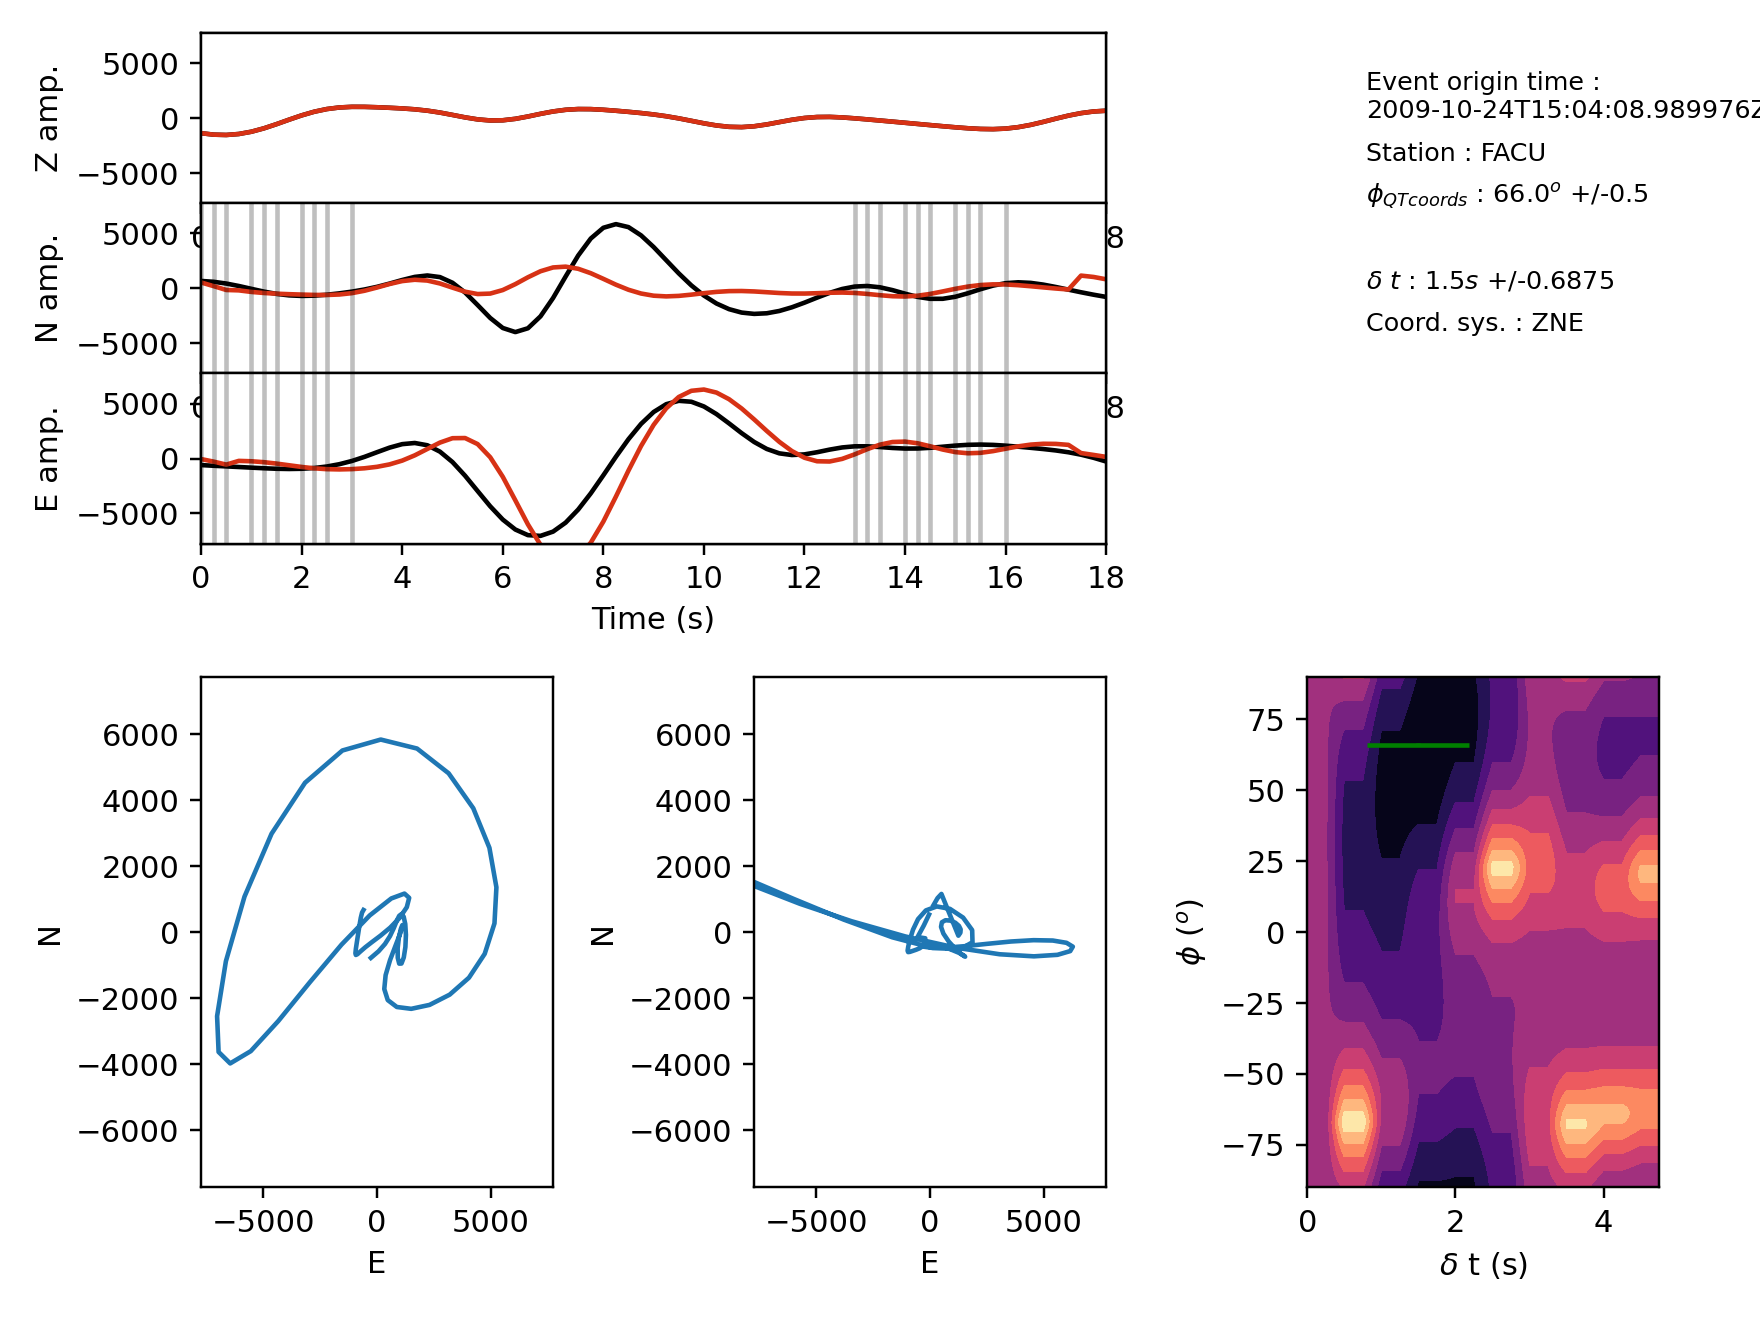

/Users/eart0504/Documents/python/github_repositories/swspy/swspy/splitting/split.py:772: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


In [50]:
# Loop over events:
for event_uid in event_uids:
    print("Processing for event:", event_uid)
    # Load data:
    mseed_path = os.path.join(datadir, event_uid)
    station = event_uid.split("_")[0]
    event_starttime = obspy.UTCDateTime(year=int(event_uid.split("_")[1][0:4]), julday=int(event_uid.split("_")[1][4:7]), 
                                        hour=int(event_uid.split("_")[2][0:2]), minute=int(event_uid.split("_")[2][2:4]),
                                       second=int(event_uid.split("_")[2][4:6]))
    aux_data_df_row_idx = aux_data_df.index[aux_data_df["STAT"]==station].tolist()[0]
    win_starttime = event_starttime + aux_data_df["WBEG"][aux_data_df_row_idx] - 5
    win_endtime = event_starttime + aux_data_df["WEND"][aux_data_df_row_idx] +5
    
    s_pick_after_starttime = win_starttime+5
    downsample_factor = 10 # Factor to downsample data by (for faster slitting)
    load_wfs_obj = swspy.io.load_waveforms(mseed_path, archive_vs_file="file", downsample_factor=downsample_factor)
    load_wfs_obj.filter = True
    load_wfs_obj.filter_freq_min_max = [0.01, 0.5]
    st = load_wfs_obj.read_waveform_data()
    
    # Calculate splitting:
    splitting_event = swspy.splitting.create_splitting_object(st, stations_in=[station], S_phase_arrival_times=[s_pick_after_starttime]) #(st, nonlinloc_event_path) #(st.select(station="ST01"), nonlinloc_event_path)
    splitting_event.overall_win_start_pre_fast_S_pick = 4.0 #0.1
    splitting_event.win_S_pick_tolerance = 1.0
    splitting_event.overall_win_start_post_fast_S_pick = (win_endtime - win_starttime) - 10 #0.2
    splitting_event.rotate_step_deg = 1.0 #2.5
    splitting_event.max_t_shift_s = 5.0
    splitting_event.n_win = 10 #5 #10
    # splitting_event.perform_sp
    splitting_event.perform_sws_analysis(coord_system="ZNE") #(coord_system="LQT") #(coord_system="ZNE")
    
    # And plot splitting result:
    splitting_event.plot(out_fname=os.path.join("output_plots", ''.join((event_uid, ".png"))))
    
    break
